In [1]:
# system / paths
import os
import sys
from pathlib import Path

# numerical / data
import numpy as np
import pandas as pd
import random

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# audio processing
import librosa
import soundfile as sf
# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# filtering and audio playback
from scipy.signal import butter, filtfilt
from IPython.display import Audio, display

# project paths
project_root = Path(os.getcwd()).parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# CWD is assumed to be notebooks/icbhi CWD = Path().resolve() # heart_and_lungsounds/ PROJECT_ROOT = CWD.parents[1]
CWD = Path().resolve()  # heart_and_lungsounds/
PROJECT_ROOT = CWD.parents[1]

from scipy.signal import butter, filtfilt
from IPython.display import Audio, display

PROC_HLS = PROJECT_ROOT / "data" / "processed" / "hls_cmds"
HLS_CSV = PROC_HLS / "hls_cmds.csv"

RAW_HLS = PROJECT_ROOT / "data" / "raw" / "hls_cmds"

HLS_AUDIO_DIRS = {
    "HS": RAW_HLS / "HS",
    "LS": RAW_HLS / "LS",
    "Mix": RAW_HLS / "Mix",
}

print("HLS_CSV:", HLS_CSV)

HLS_CSV: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\hls_cmds\hls_cmds.csv


In [2]:
hls_df = pd.read_csv(HLS_CSV)

hls_df.head()

,category,gender,location,heart_sound_type,lung_sound_type,heart_sound_id,lung_sound_id,mixed_sound_id,file_name
0,HS,F,RC,Normal,NaN,F_N_RC,NaN,NaN,F_N_RC.wav
1,HS,F,LC,Normal,NaN,F_N_LC,NaN,NaN,F_N_LC.wav
2,HS,M,RUSB,Normal,NaN,M_N_RUSB,NaN,NaN,M_N_RUSB.wav
3,HS,F,LUSB,Normal,NaN,F_N_LUSB,NaN,NaN,F_N_LUSB.wav
4,HS,F,LLSB,Normal,NaN,F_N_LLSB,NaN,NaN,F_N_LLSB.wav


In [3]:
def resolve_hls_wav_path(row) -> Path | None:
    """
    Resolve wav path using category (HS / LS / Mix) and file_name.
    """
    file_name = row["file_name"]
    category = row["category"]

    if pd.isna(file_name) or pd.isna(category):
        return None

    base_dir = HLS_AUDIO_DIRS.get(category)
    if base_dir is None:
        return None

    wav_path = base_dir / file_name
    return wav_path if wav_path.exists() else None

hls_df["wav_path"] = hls_df.apply(resolve_hls_wav_path, axis=1)
hls_df["wav_exists"] = hls_df["wav_path"].apply(lambda p: p is not None)

print("Existing files:", hls_df["wav_exists"].sum(), "/", len(hls_df))

Existing files: 245 / 245


In [4]:
TARGET_SR = 4000

def load_hls_audio(wav_path: Path, sr: int = TARGET_SR):
    y, sr_loaded = librosa.load(str(wav_path), sr=sr, mono=True)
    return y, sr_loaded

hls_ok = hls_df[hls_df["wav_exists"]].copy()

audios, srs = [], []
for p in hls_ok["wav_path"]:
    y, sr_loaded = load_hls_audio(p, sr=TARGET_SR)
    audios.append(y)
    srs.append(sr_loaded)

hls_ok["audio"] = audios
hls_ok["sr"] = srs


In [5]:
def butter_bandpass_filter(
    x: np.ndarray,
    fs: float,
    lowcut: float = 120.0,
    highcut: float = 1800.0,
    order: int = 12,
) -> np.ndarray:
    """
    12th-order Butterworth band-pass filter (zero-phase via filtfilt).
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    if low <= 0 or high >= 1:
        raise ValueError(f"Invalid bandpass range: low={lowcut}, high={highcut}, fs={fs}")

    b, a = butter(order, [low, high], btype="bandpass")
    y = filtfilt(b, a, x)
    return y

def apply_hls_bandpass(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["filtered_audio"] = df.apply(
        lambda row: butter_bandpass_filter(row["audio"], row["sr"], 120.0, 1800.0, 12),
        axis=1,
    )
    return df

hls_ok = apply_hls_bandpass(hls_ok)
hls_ok.head()


,category,gender,location,heart_sound_type,lung_sound_type,heart_sound_id,lung_sound_id,mixed_sound_id,file_name,wav_path,wav_exists,audio,sr,filtered_audio
0,HS,F,RC,Normal,NaN,F_N_RC,NaN,NaN,F_N_RC.wav,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,True,"[-0.0024108887, -0.0024719238, -0.0024719238, ...",4000,"[2.7053530801859504e-06, -0.000213117594572322..."
1,HS,F,LC,Normal,NaN,F_N_LC,NaN,NaN,F_N_LC.wav,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,True,"[-0.0047302246, -0.004852295, -0.0048828125, -...",4000,"[9.468750409511776e-07, -5.6142972088053375e-0..."
2,HS,M,RUSB,Normal,NaN,M_N_RUSB,NaN,NaN,M_N_RUSB.wav,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,True,"[0.0008544922, 0.00076293945, 0.0007019043, 0....",4000,"[6.443784114517113e-06, -6.103319865667746e-05..."
3,HS,F,LUSB,Normal,NaN,F_N_LUSB,NaN,NaN,F_N_LUSB.wav,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,True,"[0.00015258789, 0.00015258789, 0.00015258789, ...",4000,"[1.2577008465771681e-05, 4.297549614119653e-05..."
4,HS,F,LLSB,Normal,NaN,F_N_LLSB,NaN,NaN,F_N_LLSB.wav,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,True,"[-0.0025634766, -0.002166748, -0.0018310547, -...",4000,"[-0.00011685899155474251, -7.99075135233557e-0..."


In [6]:
def clean_label(x):
    if pd.isna(x):
        return None
    x = str(x).strip()
    return None if x == "" else x

hls_ok = hls_ok.copy()
hls_ok["heart_label"] = hls_ok["heart_sound_type"].apply(clean_label)
hls_ok["lung_label"]  = hls_ok["lung_sound_type"].apply(clean_label)

# Handige samengestelde label voor Mix (alleen voor inspectie/plots)
hls_ok["mix_label"] = hls_ok.apply(
lambda r: f"{r['heart_label']} + {r['lung_label']}"
    if str(r.get("category","")).strip() == "Mix" and r["heart_label"] and r["lung_label"]
    else None,
    axis=1
)

In [7]:
hls_hs_df  = hls_ok[hls_ok["category"] == "HS"].copy()
hls_ls_df  = hls_ok[hls_ok["category"] == "LS"].copy()
hls_mix_df = hls_ok[hls_ok["category"] == "Mix"].copy()

print("HS :", hls_hs_df.shape)
print("LS :", hls_ls_df.shape)
print("Mix:", hls_mix_df.shape)

# Sanity: Mix moet nu beide labels hebben (vaak)
print(
    "Mix rows with both labels present:",
    ((hls_mix_df["heart_label"].notna()) & (hls_mix_df["lung_label"].notna())).sum(),
    "/",
    len(hls_mix_df)
)

HS : (50, 17)
LS : (50, 17)
Mix: (145, 17)
Mix rows with both labels present: 145 / 145


In [8]:
from IPython.display import Audio, display

def plot_raw_vs_filtered_hls(
    row,
    time_window=(0.0, 10.0),
    fixed_ylim=(-0.5, 0.5),
):
    """
    Raw vs filtered waveform for a HLS-CMDS file, with clean styling and playback.
    """
    y_raw = row["audio"]
    y_filt = row["filtered_audio"]
    sr = row["sr"]

    if time_window is not None:
        t0, t1 = time_window
        i0 = int(t0 * sr)
        i1 = int(t1 * sr)
        y_raw_plot = y_raw[i0:i1]
        y_filt_plot = y_filt[i0:i1]
        t = np.arange(len(y_raw_plot)) / sr + t0
    else:
        y_raw_plot = y_raw
        y_filt_plot = y_filt
        t = np.arange(len(y_raw_plot)) / sr

    # ticks
    x_min, x_max = float(t[0]), float(t[-1])
    x_ticks = np.arange(np.floor(x_min), np.ceil(x_max) + 1e-9, 0.5)

    y_min, y_max = fixed_ylim
    y_ticks = np.arange(y_min, y_max + 1e-9, 0.1)

    # title info
    cat = str(row.get("category", "")).strip()
    loc = str(row.get("location", "")).strip()
    label = str(row.get("file_label", "")).strip()
    wav_name = Path(row["wav_path"]).name if "wav_path" in row else "unknown.wav"

    suptitle = f"{wav_name} | Category: {cat} | Label: {label} | Location: {loc}"

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
    fig.suptitle(suptitle, fontsize=11)

    axes[0].plot(t, y_raw_plot, color="black", linewidth=0.7)
    axes[0].set_title("Raw signal", fontsize=11)
    axes[0].set_ylabel("Amplitude")
    axes[0].set_xlim(x_min, x_max)
    axes[0].set_ylim(y_min, y_max)
    axes[0].set_xticks(x_ticks)
    axes[0].set_yticks(y_ticks)
    axes[0].grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.9)

    axes[1].plot(t, y_filt_plot, color="black", linewidth=0.7)
    axes[1].set_title("Filtered signal (12th-order Butterworth, 120–1800 Hz)", fontsize=11)
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Amplitude")
    axes[1].set_xlim(x_min, x_max)
    axes[1].set_ylim(y_min, y_max)
    axes[1].set_xticks(x_ticks)
    axes[1].set_yticks(y_ticks)
    axes[1].grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.9)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print(f"Playback (raw, fs={sr} Hz):")
    display(Audio(y_raw, rate=sr))

    print(f"Playback (filtered, fs={sr} Hz):")
    display(Audio(y_filt, rate=sr))

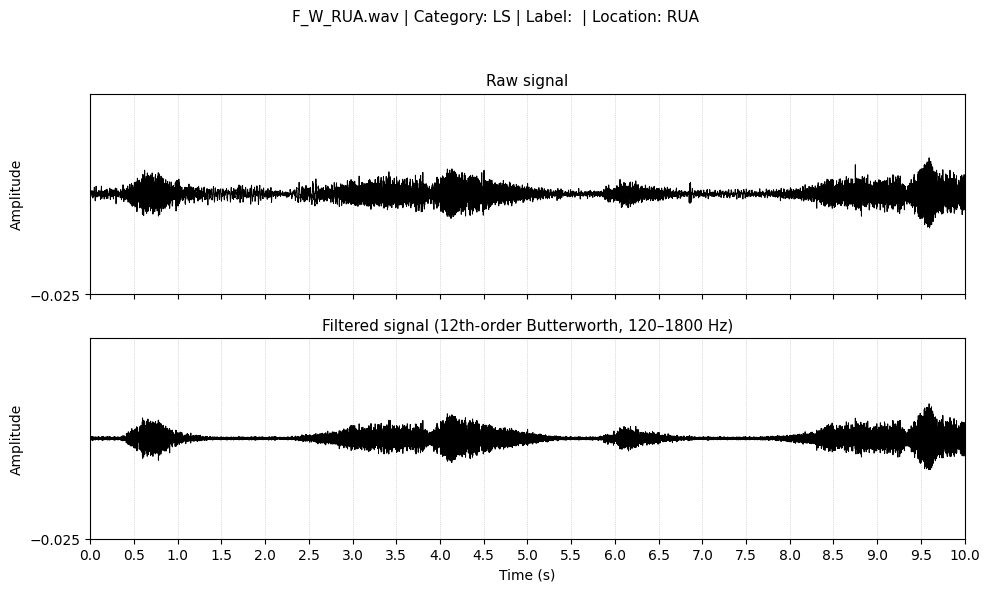

Playback (raw, fs=4000 Hz):


Playback (filtered, fs=4000 Hz):


In [25]:
example_row = hls_ok.query("file_name == 'F_W_RUA.wav'").iloc[0]

# Zelfde stijl als jouw voorbeeld: 0–10 s, vaste y-as
plot_raw_vs_filtered_hls(
    example_row,
    time_window=(0.0, 10.0),
    fixed_ylim=(-0.025, 0.025)   # pas aan als je een andere schaal wilt
)


In [10]:
def make_hls_segments(
    df: pd.DataFrame,
    audio_col="filtered_audio",
    window_sec=2.5,
    hop_sec=1.0,
):
    segments = []
    for _, row in df.iterrows():
        y = row[audio_col]
        sr = int(row["sr"])
        win = int(round(window_sec * sr))
        hop = int(round(hop_sec * sr))

        if len(y) < win:
            continue

        idx = 0
        start = 0
        while start + win <= len(y):
            end = start + win
            segments.append({
                "category": row.get("category", None),
                "location": row.get("location", None),
                "gender": row.get("gender", None),
                "file_name": Path(str(row.get("wav_path",""))).name,
                "wav_path": str(row.get("wav_path","")),
                # labels (keep both; may be None depending on subset)
                "heart_label": row.get("heart_label", None),
                "lung_label": row.get("lung_label", None),
                "mix_label": row.get("mix_label", None),
                "segment_index": idx,
                "seg_start_sec": start / sr,
                "seg_end_sec": end / sr,
                "audio_segment": y[start:end],
                "sr": sr,
            })
            start += hop
            idx += 1

    return pd.DataFrame(segments)

In [11]:
hls_hs_segments  = make_hls_segments(hls_hs_df)
hls_ls_segments  = make_hls_segments(hls_ls_df)
hls_mix_segments = make_hls_segments(hls_mix_df)

print(hls_hs_segments.shape, hls_ls_segments.shape, hls_mix_segments.shape)

(650, 13) (650, 13) (1885, 13)


In [12]:
import ipywidgets as widgets
from IPython.display import display, clear_output, Audio

def segment_browser_widget(
    segments_df: pd.DataFrame,
    id_col: str,
    title_col: str = None,
    label_col: str = None,
    fixed_ylim=None,
):
    df = segments_df.copy()

    # Sort segments within each recording
    sort_cols = ["segment_index"] if "segment_index" in df.columns else ["seg_start_sec"]
    df = df.sort_values([id_col] + sort_cols)

    disp_col = title_col if title_col is not None else id_col

    # Build dropdown options with clean display names
    options = []

    if disp_col == id_col:
        # Use id_col for both, but display only filename if it's a path
        unique_ids = pd.Series(df[id_col].unique()).dropna().sort_values()
        for v in unique_ids.tolist():
            try:
                display_name = Path(str(v)).name
            except Exception:
                display_name = str(v)
            options.append((display_name, v))
    else:
        unique_rows = (
            df[[id_col, disp_col]]
            .drop_duplicates()
            .dropna(subset=[id_col])
            .sort_values(disp_col)
        )
        for _, r in unique_rows.iterrows():
            try:
                display_name = Path(str(r[disp_col])).name
            except Exception:
                display_name = str(r[disp_col])
            options.append((display_name, r[id_col]))

    dropdown = widgets.Dropdown(
        options=options,
        description="Recording:",
        layout=widgets.Layout(width="520px"),
    )

    prev_btn = widgets.Button(description="Previous", layout=widgets.Layout(width="120px"))
    next_btn = widgets.Button(description="Next", layout=widgets.Layout(width="120px"))
    idx_label = widgets.Label(value="Segment: - / -", layout=widgets.Layout(width="160px"))

    out = widgets.Output()
    state = {"seg_pos": 0, "current_id": None, "current_sub": None}

    def _render():
        with out:
            clear_output(wait=True)

            rid = dropdown.value
            sub = df[df[id_col] == rid].reset_index(drop=True)
            state["current_id"] = rid
            state["current_sub"] = sub

            if len(sub) == 0:
                print("No segments found.")
                idx_label.value = "Segment: 0 / 0"
                return

            state["seg_pos"] = max(0, min(state["seg_pos"], len(sub) - 1))
            row = sub.iloc[state["seg_pos"]]

            seg_idx = int(row["segment_index"]) if "segment_index" in row else state["seg_pos"]
            start_s = float(row.get("seg_start_sec", np.nan))
            end_s = float(row.get("seg_end_sec", np.nan))

            label_txt = ""
            if label_col is not None and label_col in sub.columns:
                label_txt = f" | Label: {row[label_col]}"

            # Show only the filename in the title (instead of full path)
            try:
                rec_name = Path(str(rid)).name
            except Exception:
                rec_name = str(rid)

            idx_label.value = f"Segment: {state['seg_pos']+1} / {len(sub)}"

            y = row["audio_segment"]
            sr = int(row["sr"])

            t = np.arange(len(y)) / sr
            fig, ax = plt.subplots(figsize=(10, 3))
            ax.plot(t, y, color="black", linewidth=0.7)

            if fixed_ylim is not None:
                ax.set_ylim(*fixed_ylim)

            ax.grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.9)
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Amplitude")
            ax.set_title(
                f"{rec_name} | Segment {seg_idx} | {start_s:.2f}s–{end_s:.2f}s{label_txt}",
                fontsize=11,
            )
            plt.tight_layout()
            plt.show()

            display(Audio(y, rate=sr))

    def _on_change(change):
        state["seg_pos"] = 0
        _render()

    def _on_prev(_):
        if state["current_sub"] is None:
            _render()
            return
        state["seg_pos"] = max(0, state["seg_pos"] - 1)
        _render()

    def _on_next(_):
        if state["current_sub"] is None:
            _render()
            return
        state["seg_pos"] = min(len(state["current_sub"]) - 1, state["seg_pos"] + 1)
        _render()

    dropdown.observe(_on_change, names="value")
    prev_btn.on_click(_on_prev)
    next_btn.on_click(_on_next)

    controls = widgets.HBox([dropdown, prev_btn, next_btn, idx_label])
    display(controls, out)
    _render()


In [13]:
segment_browser_widget(
    segments_df=hls_hs_segments,
    id_col="wav_path",        # opnamekeuze op bestand
    title_col="wav_path",
    label_col="file_label",   # toont heart_sound_type / lung_sound_type afhankelijk van category
    fixed_ylim=None,
)

Output()

In [14]:
import re

CWD = Path().resolve()
PROJECT_ROOT = CWD.parents[1]

OUT_ROOT = PROJECT_ROOT / "data" / "processed" / "hls_cmds"
OUT_ROOT.mkdir(parents=True, exist_ok=True)

def make_relative_path(p):
    if not isinstance(p, str):
        return p
    path = Path(p)
    if path.is_absolute():
        try:
            return path.relative_to(PROJECT_ROOT).as_posix()
        except ValueError:
            return p
    return p

def safe_stem(s: str) -> str:
    """Filesystem-safe stem from a path or filename."""
    stem = Path(str(s)).stem
    stem = re.sub(r"\s+", "_", stem)
    stem = re.sub(r"[^A-Za-z0-9_\-]+", "", stem)
    return stem

def export_segments_audio_and_csv(df, kind: str):
    """
    kind: 'hs' | 'ls' | 'mix'
    Expects columns: wav_path, segment_index, audio_segment, sr
    Adds: audio_path (segment wav path)
    Writes: segment wavs + CSV metadata
    """
    df = df.copy()

    # ---- SR check
    if "sr" not in df.columns:
        raise KeyError(f"[{kind}] expected column 'sr' in dataframe.")
    sr_values = df["sr"].unique()
    if len(sr_values) != 1:
        raise ValueError(f"[{kind}] expected exactly one sampling rate, found: {sr_values}")
    SR = int(sr_values[0])

    # ---- Output dirs per kind + SR
    audio_out_dir = OUT_ROOT / f"{kind}_audio_{SR}hz_bp_segments"
    audio_out_dir.mkdir(parents=True, exist_ok=True)

    # ---- Write audio segments idempotently
    audio_paths = []
    n_written = 0
    n_skipped = 0

    for _, row in df.iterrows():
        if "wav_path" not in row:
            raise KeyError(f"[{kind}] expected column 'wav_path' in dataframe.")
        if "segment_index" not in row:
            raise KeyError(f"[{kind}] expected column 'segment_index' in dataframe.")
        if "audio_segment" not in row:
            raise KeyError(f"[{kind}] expected column 'audio_segment' in dataframe.")

        stem = safe_stem(row["wav_path"])
        seg_i = int(row["segment_index"])

        fname = f"{stem}_seg{seg_i:03d}.wav"
        out_path = audio_out_dir / fname

        if out_path.exists():
            info = sf.info(out_path)
            if info.samplerate != SR:
                raise ValueError(
                    f"[{kind}] SR mismatch for existing file {out_path}: {info.samplerate} != {SR}"
                )
            n_skipped += 1
        else:
            y = np.asarray(row["audio_segment"], dtype=np.float32)
            sf.write(out_path, y, SR, subtype="FLOAT")
            n_written += 1

        # store project-relative path for portability
        rel_audio_path = out_path.relative_to(PROJECT_ROOT).as_posix()
        audio_paths.append(rel_audio_path)

    print(f"[{kind}] audio export | written: {n_written} | skipped: {n_skipped} | dir: {audio_out_dir}")

    # ---- Update df: shorten wav_path + add audio_path
    df["wav_path"] = df["wav_path"].apply(make_relative_path)
    df["audio_path"] = audio_paths

    # ---- Drop heavy columns (idempotent)
    df = df.drop(columns=["audio_segment", "sr"], errors="ignore")

    # ---- Write CSV
    out_csv = OUT_ROOT / f"{kind}_segments.csv"
    df.to_csv(out_csv, index=False)
    print(f"[{kind}] metadata CSV written: {out_csv} | rows: {len(df)}")

    return df  # return cleaned df if you want to keep using it in-memory

In [15]:
hls_hs_segments_clean  = export_segments_audio_and_csv(hls_hs_segments,  kind="hs")

[hs] audio export | written: 650 | skipped: 0 | dir: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\hls_cmds\hs_audio_4000hz_bp_segments
[hs] metadata CSV written: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\hls_cmds\hs_segments.csv | rows: 650


In [16]:
hls_ls_segments_clean  = export_segments_audio_and_csv(hls_ls_segments,  kind="ls")

[ls] audio export | written: 650 | skipped: 0 | dir: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\hls_cmds\ls_audio_4000hz_bp_segments
[ls] metadata CSV written: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\hls_cmds\ls_segments.csv | rows: 650


In [17]:
hls_mix_segments_clean = export_segments_audio_and_csv(hls_mix_segments, kind="mix")

[mix] audio export | written: 1885 | skipped: 0 | dir: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\hls_cmds\mix_audio_4000hz_bp_segments
[mix] metadata CSV written: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\hls_cmds\mix_segments.csv | rows: 1885
